In [2]:
!pip install -q datasets transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00


In [64]:
import torch
import torchvision
import numpy as np
import evaluate
from datasets import load_dataset
from huggingface_hub import notebook_login
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import DefaultDataCollator
from transformers import AutoImageProcessor
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import matplotlib.pyplot as plt

In [5]:
from huggingface_hub import notebook_login

notebook_login()

In [65]:
beans_train = load_dataset("beans", split="train")

README.md:   0%|          | 0.00/4.95k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

In [66]:
beans_train

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 1034
})

In [67]:
beans_train.features

{'image_file_path': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'labels': ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)}

In [68]:
labels_names = {
   0: "angular_leaf_spot",
   1: "bean_rust",
   2: "healthy",
}

def display_random_images(dataset, num_images=4):

   num_rows = 2
   num_cols = np.ceil(num_images / num_rows).astype(int)

   plt.figure(figsize=(num_cols * 3, num_rows * 3))
   indices = np.random.choice(range(len(dataset)), size=num_images, replace=False)

   for i, idx in enumerate(indices, 1):
       idx = int(idx)
       image = dataset[idx]['image']
       label = dataset[idx]['labels']
       label_name = labels_names.get(label, "Unknown")

       plt.subplot(num_rows, num_cols, i)
       plt.imshow(image)
       plt.title(f"{label_name} ({label})")
       plt.axis('off')

   plt.tight_layout()
   plt.show()

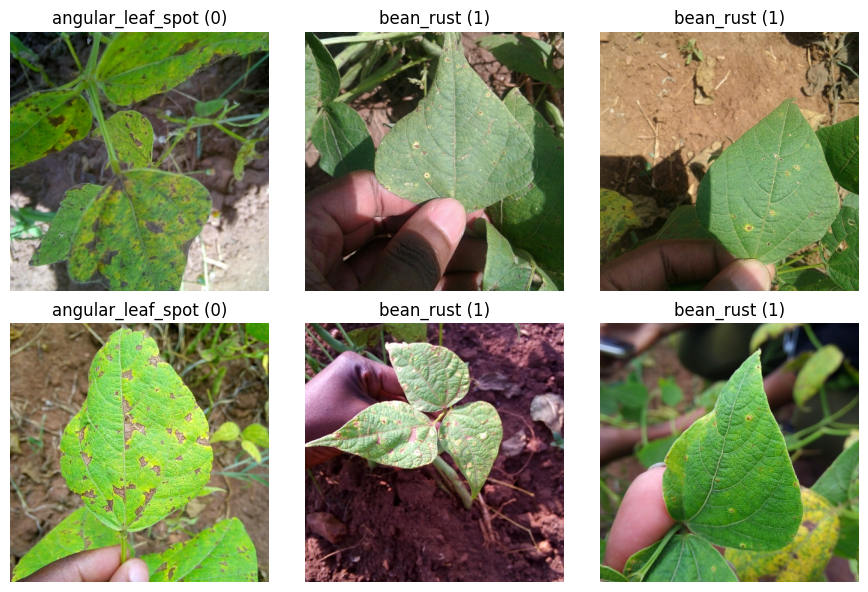

In [69]:
display_random_images(beans_train, num_images=6)

## Preprocess Data

In [70]:
beans_train = beans_train.train_test_split(test_size=0.2)

In [71]:
labels = beans_train["train"].features["labels"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
   label2id[label] = str(i)
   id2label[str(i)] = label

In [72]:
id2label

{'0': 'angular_leaf_spot', '1': 'bean_rust', '2': 'healthy'}

## Load pre-trained model

In [73]:
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

normalize = Normalize(mean=image_processor.image_mean,
                  	std=image_processor.image_std)

size = (
	image_processor.size["shortest_edge"]
	if "shortest_edge" in image_processor.size
	else (image_processor.size["height"], image_processor.size["width"])
)

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(examples):

	examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
	del examples["image"]
	return examples

beans_transformed = beans_train.with_transform(transforms)

data_collator = DefaultDataCollator()

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [89]:
beans_transformed['test'][0]

{'image_file_path': '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/healthy/healthy_train.106.jpg',
 'labels': 2,
 'pixel_values': tensor([[[-0.0980, -0.1216, -0.1059,  ...,  0.3333, -0.0118, -0.4118],
          [-0.0510, -0.0824, -0.0824,  ...,  0.3490,  0.0431, -0.3569],
          [-0.0196, -0.0431, -0.0510,  ...,  0.3569,  0.1294, -0.1922],
          ...,
          [-0.0196, -0.0353, -0.0588,  ...,  0.3255,  0.5843,  1.0000],
          [-0.0118, -0.0353, -0.0667,  ...,  0.2863,  0.5451,  1.0000],
          [-0.0118, -0.0353, -0.0745,  ...,  0.2549,  0.5137,  1.0000]],
 
         [[ 0.3647,  0.3412,  0.3569,  ...,  0.3255, -0.0745, -0.5137],
          [ 0.4118,  0.3804,  0.3804,  ...,  0.3725,  0.0118, -0.4196],
          [ 0.4431,  0.4118,  0.4039,  ...,  0.4118,  0.1529, -0.2078],
          ...,
          [ 0.4196,  0.4118,  0.4039,  ...,  0.0431,  0.3725,  0.8745],
          [ 0.4275,  0.4118,  0.

In [41]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [74]:
from evaluate import load

accuracy = load("accuracy")
def compute_metrics(eval_pred):
   predictions, labels = eval_pred
   predictions = np.argmax(predictions, axis=1)

   return accuracy.compute(predictions=predictions,
                           references=labels)

## Training the model

In [75]:
model = AutoModelForImageClassification.from_pretrained(
   checkpoint,
   num_labels=len(labels),
   id2label=id2label,
   label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model is loaded on: {device}")

Model is loaded on: cuda


In [98]:
args = TrainingArguments(
	output_dir="./vit-base-patch16-finetuned-beans",
	remove_unused_columns=False,
	evaluation_strategy="epoch",
	save_strategy="epoch",
	learning_rate=5e-5,
	per_device_train_batch_size=16,
	gradient_accumulation_steps=4,
	per_device_eval_batch_size=16,
	num_train_epochs=3,
	warmup_ratio=0.1,
	logging_steps=10,
	load_best_model_at_end=True,
	metric_for_best_model="accuracy",
  push_to_hub=True,
  report_to='tensorboard'
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [99]:
trainer = Trainer(
	model=model,
	args=args,
	data_collator=data_collator,
	train_dataset=beans_transformed["train"],
	eval_dataset=beans_transformed["test"],
	tokenizer=image_processor,
	compute_metrics=compute_metrics,
)

<ipython-input-99-01e4aef4f096>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [80]:
trainer.evaluate()

{'eval_loss': 1.1209073066711426,
 'eval_model_preparation_time': 0.0066,
 'eval_accuracy': 0.2222222222222222,
 'eval_runtime': 4.2327,
 'eval_samples_per_second': 48.905,
 'eval_steps_per_second': 3.071}

In [100]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.349300,0.280531,0.942029
2,0.243500,0.221510,0.946860
3,0.172100,0.161757,0.975845


In [101]:
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

events.out.tfevents.1733165008.79449f34b168.401.3:   0%|          | 0.00/7.19k [00:00<?, ?B/s]

***** train metrics *****
  epoch                    =         3.0
  total_flos               = 179055472GF
  train_loss               =      0.2368
  train_runtime            =  0:02:21.69
  train_samples_per_second =      17.509
  train_steps_per_second   =       0.275


In [102]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.9662
  eval_loss               =      0.201
  eval_runtime            = 0:00:03.64
  eval_samples_per_second =     56.772
  eval_steps_per_second   =      3.565


In [103]:
trainer.push_to_hub()

events.out.tfevents.1733165171.79449f34b168.401.4:   0%|          | 0.00/405 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/osmanh/vit-base-patch16-finetuned-beans/commit/c6689f48be19cad94070af202be5072016fe2c21', commit_message='End of training', commit_description='', oid='c6689f48be19cad94070af202be5072016fe2c21', pr_url=None, repo_url=RepoUrl('https://huggingface.co/osmanh/vit-base-patch16-finetuned-beans', endpoint='https://huggingface.co', repo_type='model', repo_id='osmanh/vit-base-patch16-finetuned-beans'), pr_revision=None, pr_num=None)

## Inference

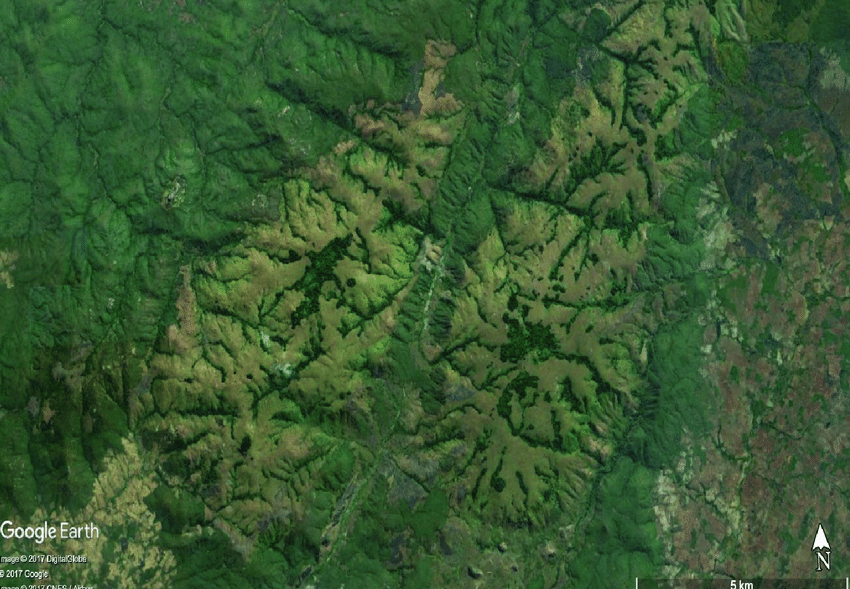

In [104]:
from PIL import Image
import requests

url = 'https://huggingface.co/nielsr/convnext-tiny-finetuned-eurostat/resolve/main/forest.png'
image = Image.open(requests.get(url, stream=True).raw)
image

In [105]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "osmanh/vit-base-patch16-finetuned-beans"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [106]:
# prepare image for the model
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [107]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

## Pipeline API

In [108]:
from transformers import pipeline

pipe = pipeline("image-classification", repo_name)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [109]:
pipe(image)

[{'label': 'angular_leaf_spot', 'score': 0.5320438742637634},
 {'label': 'bean_rust', 'score': 0.47355952858924866},
 {'label': 'healthy', 'score': 0.44754159450531006}]

In [110]:
pipe = pipeline("image-classification",
                model=model,
                feature_extractor=image_processor)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [111]:
pipe(image)

[{'label': 'angular_leaf_spot', 'score': 0.5320438742637634},
 {'label': 'bean_rust', 'score': 0.47355952858924866},
 {'label': 'healthy', 'score': 0.44754159450531006}]